In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed, parallel_backend
import concurrent.futures
import numpy as np

In [2]:
enfermedades = pd.read_excel('archivos/CIE.xlsx')
new_df=  pd.read_csv ('archivos/NewDataAll.csv', low_memory=False)

In [3]:
# Preprocesar los datos
new_df['caudef']
enfermedades2 = enfermedades.copy()
enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] = enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] + "X"

new_df2 = pd.merge(new_df, enfermedades2, left_on='caudef', right_on='CAUSA', how='left')
new_df2 = new_df2.dropna()
causas_infecciones = new_df2.loc[new_df2["DESCRIP"].str.contains("Infecciones|infecciones|infeccion|Infección|Infeccion|infección")]
causas_vih = new_df2.loc[new_df2["DESCRIP"].str.contains("VIH|vih|SIDA")]

In [4]:
# Filtrar las características y la variable objetivo
new_df2['VIH'] = 0
indices_vih = new_df2[new_df2['DESCRIP'].str.contains("VIH|vih|SIDA")].index
new_df2.loc[indices_vih, 'VIH'] = 1

In [5]:
new_df2.loc[new_df2["DESCRIP"].str.contains("VIH|vih|SIDA")]

,Unnamed: 0,depreg,mupreg,mesreg,añoreg,depocu,mupocu,sexo,diaocu,mesocu,...,nacdif,dredif,mredif,caudef,asist,ocur,cerdef,CAUSA,DESCRIP,VIH
448,448,1,101,11,9,1,101,1,13,11,...,0,1,101,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
679,679,1,101,4,9,1,101,2,29,4,...,0,1,101,B207,1,1,1,B207,"Enfermedad por VIH, resultante en infecciones ...",1
705,705,1,101,3,9,1,101,1,28,2,...,0,1,101,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
735,735,1,101,5,9,1,101,2,5,5,...,0,1,101,B200,1,1,1,B200,"Enfermedad por VIH, resultante en infección po...",1
845,845,1,101,6,9,1,101,1,31,5,...,0,1,101,B24X,1,1,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919272,61522,1,101,4,2020,1,101,1,15,4,...,320,1,101,B238,1,2,1,B238,"Enfermedad por VIH, resultante en otras afecci...",1
926802,69052,8,802,8,2020,9,901,1,4,8,...,320,9,901,B24X,1,6,1,B24X,Enfermedad por virus de la inmunodeficiencia h...,1
929114,71364,19,1905,9,2020,19,1902,1,16,8,...,320,19,1902,B218,5,6,9,B218,"Enfermedad por VIH, resultante en otros tumore...",1
939519,81769,1,101,6,2020,1,101,1,29,6,...,320,22,2205,B227,1,4,1,B227,"Enfermedad por VIH, resultante en enfermedades...",1


In [6]:
# df
data = new_df2
# Hacer una muestra de DataFrame
sample_size = 400000  # Tamaño de la muestra deseada
data.pop('Unnamed: 0')
data.pop('CAUSA')
data.pop('DESCRIP')
data['mnadif'] = pd.to_numeric(data['mnadif'], errors='coerce').fillna(-1).astype(int)
data_sample = data.sample(n=sample_size, random_state=42)  # n es el número de filas a extraer

X = data_sample.drop('caudef', axis=1)  # Variables predictoras
y = data_sample['caudef']  # Variable objetivo codificada

In [7]:
from sklearn.preprocessing import LabelEncoder

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar la variable objetivo
y_encoded = label_encoder.fit_transform(y)

# Asignar las etiquetas codificadas a la variable objetivo
data_sample['caudef_encoded'] = y_encoded
data_sample.pop('caudef')

841138    I871
555404    K922
893482    I219
755682    J189
596024    J189
          ... 
782798    P529
916067    I509
10489     X954
250192    O268
908012    N189
Name: caudef, Length: 400000, dtype: object

In [8]:
X = data_sample.drop('caudef_encoded', axis=1)  # Variables predictoras
y = data_sample['caudef_encoded']  # Variable objetivo codificada

In [9]:
import statsmodels.api as sm

# Too many variables, but we need to make sure which ones to use.
# Apply stepwise regression to figure out p-value
# Define dependent variable and independent variables

# Perform stepwise regression
def forward_stepwise(X, y, initial_list=[], threshold_in=0.01, verbose=True):
    included = list(initial_list)
    excluded = [col for col in X.columns if col not in included]
    
    while True:
        changed = False
        excluded_dict = {}
        # Forward step
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            p_value = model.pvalues[new_column]
            excluded_dict[new_column] = p_value
        
        best_column, best_pvalue = min(excluded_dict.items(), key=lambda x: x[1])
        
        if best_pvalue < threshold_in:
            included.append(best_column)
            excluded.remove(best_column)
            
            if verbose:
                print("Add {:30} with p-value {:.6}".format(best_column, best_pvalue))
            
            changed = True
        # Termination condition: no more variables can be added
        if not changed:
            break
    
    return included

In [10]:
# Run the forward stepwise function 
# These will be the variables used for the model
selected_columns = forward_stepwise(X, y)

Add sexo                           with p-value 0.0
Add perdif                         with p-value 0.0
Add nacdif                         with p-value 0.0
Add dredif                         with p-value 0.0
Add asist                          with p-value 0.0
Add depreg                         with p-value 0.0
Add mupreg                         with p-value 0.0
Add VIH                            with p-value 0.0
Add ocur                           with p-value 6.1851e-196
Add ecidif                         with p-value 5.25664e-192
Add añoocu                         with p-value 2.46325e-71
Add mredif                         with p-value 3.85183e-52
Add añoreg                         with p-value 1.44546e-22
Add depocu                         with p-value 2.5025e-22
Add mupocu                         with p-value 0.000465354


In [11]:
selected_columns = [
    'sexo',
    'asist',
    'mredif',
    'mupocu',
    'depocu',
    'perdif',
    'nacdif',
    'ecidif',
    'ocur',
    'añoocu',
    'añoreg'
]
X = data_sample[selected_columns]
y = data_sample['VIH']

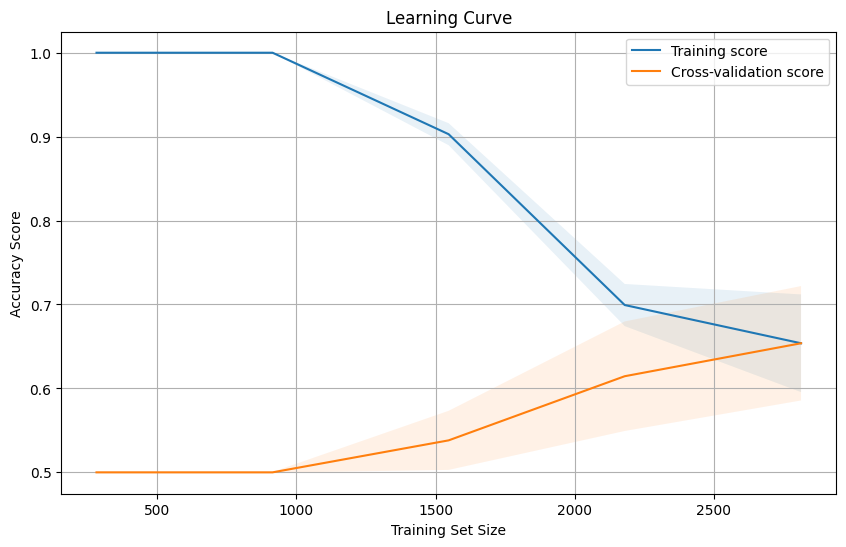

Matriz de Confusión:
[[67753 11815]
 [  235   197]]
Accuracy: 0.849375
Sensitivity: 0.45601851851851855
Specificity: 0.8515106575507742


In [12]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar submuestreo de la clase mayoritaria
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Crear el modelo de redes neuronales
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)  

# Calcular la curva de aprendizaje en paralelo
with parallel_backend('threading', n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train_resampled, y_train_resampled, cv=5)

# Calcular las medias y desviaciones estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')

# Rellenar la región entre ± una desviación estándar del puntaje de entrenamiento
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
# Rellenar la región entre ± una desviación estándar del puntaje de validación cruzada
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Entrenar el modelo
model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)

# Calcular la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calcular la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(confusion)

# Calcular la sensibilidad y especificidad
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

In [13]:
# Realizar validación cruzada
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)

# Calcular el promedio de los puntajes de validación cruzada
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_mean)
print("Standard deviation of cross-validation scores:", cv_std)

Cross-validation scores: [0.5625     0.58096591 0.71875    0.56187767 0.73684211]
Mean cross-validation score: 0.6321871362989785
Standard deviation of cross-validation scores: 0.07857369080878077
